In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
import cv2
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift,estimate_bandwidth
from sklearn.metrics import silhouette_score

In [14]:
!pip install opencv-python

In [2]:
#pip install threadpoolctl -U

<h1 style="color:red">Baseline Pipiline</h1>

In [14]:
# Load Data
def Load_data():
    data = pd.read_csv('./Bank-Data.csv')
    return data

In [15]:
# Data Cleaning
def CleanFunc(data):
    # Impute missing values (mean/mode imputation)
    for column in data.columns:
        if data[column].dtype == 'object':
            # Use mode for categorical columns
            data[column].fillna(data[column].mode()[0], inplace=True)
        else:
            #  mean for numerical columns
            data[column].fillna(data[column].mean(), inplace=True)
    print(f"Data after imputing missing values: {data.shape}")
    
    # One-hot encoding for categorical variables
    categorical_cols = data.select_dtypes(include=['object']).columns
    data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
    
    return data

## Preprocessing steps all in one fucnions

In [16]:
def preprocessing(data,columns,dropna=False,replace_outliers=False,scale=False,target=None,):

#Drop columns with missing values greater than 40% of total values
    cols = data.columns[data.isna().sum() * 100 / len(data) > 40]
    data.drop(columns=cols, axis=1, inplace=True)
    print(f"Dropped columns with more than 40% missing values: {list(cols)}")

    if target:
        # Drop any row in target with missing values
        initial_rows = data.shape[0]
        data.drop(data[data[target].isna()].index, inplace=True)
        dropped_rows = initial_rows - data.shape[0]
        print(f"Dropped {dropped_rows} rows with missing target values.")

    if dropna:
        # Drop any row with missing values
        initial_rows = data.shape[0]
        data.dropna(inplace=True)
        dropped_rows = initial_rows - data.shape[0]
        print(f"Dropped {dropped_rows} rows with missing values.")

    if replace_outliers:
        outliers_replaced = 0
        for col in columns:
            # Skip categorical columns (if any)
            if data[col].dtype == object:
                continue
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            # Replace outliers with Minimum and Maximum values
            before_outliers = data[col].isna().sum()
            data[col] = np.where(
                data[col] < (Q1 - (1.5 * IQR)),
                Q1 - 1.5 * IQR,
                np.where(data[col] > (Q3 + (1.5 * IQR)), Q3 + (1.5 * IQR), data[col]),
            )
            after_outliers = data[col].isna().sum()
            outliers_replaced += before_outliers - after_outliers
        data.fillna(0, inplace=True)
        print(f"Replaced {outliers_replaced} outliers.")

    if scale:
        numerical_columns = split_categorical_and_numeric(data)[1]
        # Scale the data such that all columns are in the range 0 to 1
        scaler = StandardScaler()
        data[numerical_columns] = scaler.fit_transform(
            data[numerical_columns]
        )  # Scaling and normalizing numerical data
        print(f"Scaled columns: {columns}")

    return data


# Feature Engineering

In [17]:
def feature_engineering(df):
    # List All Unique Values in 'Income_Category'
    unique_income_categories = df['Income_Category'].unique()
    print(unique_income_categories)

    unique_education_level_categories = df['Education_Level'].unique()
    print(unique_education_level_categories)

    # Drop rows where 'Income_Category' is 'Unknown'
    df = df[df['Income_Category'] != 'Unknown']

    # Drop rows where 'Education_Level' is 'Unknown'
    df = df[df['Income_Category'] != 'Unknown']

    income_mapping = {
        'Less than $40K': 0,
        '$40K - $60K': 1,
        '$60K - $80K': 2,
        '$80K - $120K': 3,
        '$120K +': 4
    }

    education_mapping = {
        'Uneducated': 0,
        'High School': 1,
        'College': 2,
        'Graduate': 3,
        'Post-Graduate': 4,
        'Doctorate': 5
    }

    # Apply the mapping to the 'Income_Category' column
    df['Income_Category_Label'] = df['Income_Category'].map(income_mapping)

    # Apply the mapping to the 'Education_Level' column
    df['Education_Level_Label'] = df['Education_Level'].map(education_mapping)

    # drop the original 'Income_Category' column
    df.drop(columns=['Income_Category'], inplace=True)

    # drop the original 'Education_Level' column
    df.drop(columns=['Education_Level'], inplace=True)

    return df  

In [18]:
def split_categorical_and_numeric(data):
    cat_columns = []
    num_columns = []
    col = data.columns
    for i in col:
        if data[i].dtypes == object:
            cat_columns.append(i)
        elif data[i].dtypes == float:
            num_columns.append(i)
        elif data[i].dtypes == int:
            num_columns.append(i)
    return cat_columns, num_columns

# One-Hot Encoding

In [19]:
def encode_categorical(df: pd.DataFrame, cat_cols, encoding_type) -> pd.DataFrame:
    if not cat_cols:
        cat_cols, _ = split_categorical_and_numeric(df)
    if encoding_type == "onehot":
        df = pd.get_dummies(df, columns=cat_cols)
    elif encoding_type == "label":
        LE = LabelEncoder()
        for col in cat_cols:
            df[col] = df[[col]].apply(LE.fit_transform)
    return df

# Correlation Heatmap

In [20]:
def plot_correlation_matrix(df, figsize=(12, 12)):
    plt.figure(figsize=figsize)
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.show()

    print("Descriptive Statistics:")
    print(df.describe())

# TSNE & PCA Analysis

In [21]:
def plot_PCA_TSNE(df: pd.DataFrame):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df)
    _df = df.copy()
    _df["PCA1"] = pca_result[:, 0]
    _df["PCA2"] = pca_result[:, 1]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PCA1", y="PCA2", data=_df)

    plt.title("PCA")
    plt.show()

    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(df)
    _df["TSNE1"] = tsne_result[:, 0]
    _df["TSNE2"] = tsne_result[:, 1]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="TSNE1", y="TSNE2", data=_df)
    
    plt.title("t-SNE")
    plt.show()

    return pca_result, tsne_result, _df

# MEAN SHIFT Function

In [51]:
def mean_shift(data, bandwidth=0.5):
    
    print(f"Using bandwidth: {bandwidth}")
    model = MeanShift(bandwidth=bandwidth)
    labels = model.fit_predict(data)
    
    # Ensure we have at least 2 clusters
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters < 2:
        raise ValueError(f"Number of clusters found is {n_clusters}. Adjust bandwidth or preprocess the data.")
    
    silhouette_avg = silhouette_score(data, labels)
    print(f"Silhouette Score: {silhouette_avg}")
    return labels

In [23]:
def visualize_clusters(data, labels):
    """
    Visualize clustering results using a scatter plot.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
    plt.title("Mean Shift Clustering Results")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label="Cluster")
    plt.show()

<h1 style="color:green">Calling all Function Sequentially </h1>

# Data Cleaning fucntion calling

In [34]:
data = Load_data()
clean_data = CleanFunc(data)
clean_data

Data after imputing missing values: (10127, 23)


,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,768805383,45,3,39,5,1,3,12691.0,777,11914.0,...,0,0,0,1,0,0,0,0,0,0
1,818770008,49,5,44,6,1,2,8256.0,864,7392.0,...,1,0,0,0,0,1,0,0,0,0
2,713982108,51,3,36,4,1,0,3418.0,0,3418.0,...,0,0,0,0,1,0,0,0,0,0
3,769911858,40,4,34,3,4,1,3313.0,2517,796.0,...,0,1,0,0,0,1,0,0,0,0
4,709106358,40,3,21,5,1,0,4716.0,0,4716.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,2,40,3,2,3,4003.0,1851,2152.0,...,1,0,1,0,0,0,0,0,0,0
10123,710638233,41,2,25,4,2,3,4277.0,2186,2091.0,...,0,0,1,0,0,0,0,0,0,0
10124,716506083,44,1,36,5,3,4,5409.0,0,5409.0,...,0,0,0,0,0,1,0,0,0,0
10125,717406983,30,2,36,4,3,3,5281.0,0,5281.0,...,0,1,1,0,0,0,0,0,0,0


# Preprocessing steps exectution

In [35]:
data = preprocessing(data, data.columns, dropna=True, replace_outliers=True, scale=True)

Dropped columns with more than 40% missing values: []
Dropped 0 rows with missing values.
Replaced 0 outliers.
Scaled columns: Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')


# Feature Engineering calling

In [36]:
data = feature_engineering(data)
data.head()

['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']
['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Marital_Status,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2,Income_Category_Label,Education_Level_Label
0,0.802878,Existing Customer,-0.165368,M,0.503368,Married,Blue,0.392971,0.763943,-1.414034,...,0.718980,2.436489,-1.297191,-0.973954,2.375918,-0.775882,-0.771590,0.784537,2,1.0
1,2.156861,Existing Customer,0.333718,F,2.043199,Single,Blue,1.036214,1.407306,-1.414034,...,0.092940,2.436489,-1.229194,-1.357433,2.375918,-0.616276,-0.934914,0.917413,0,3.0
2,-0.682769,Existing Customer,0.583262,M,0.503368,Married,Blue,0.007025,0.120579,-1.414034,...,-0.457233,2.436489,-0.953506,-1.911349,2.375918,-0.997155,-1.094636,1.094580,3,3.0
3,0.832862,Existing Customer,-0.789227,F,1.273283,Unknown,Blue,-0.250272,-0.522785,1.810811,...,-0.820230,2.436489,-1.284702,-1.911349,2.375918,1.759686,-0.592085,0.607370,0,1.0
4,-0.814896,Existing Customer,-0.789227,M,0.503368,Married,Blue,-1.922704,0.763943,-1.414034,...,-0.277534,2.436489,-1.448912,-1.570478,2.375918,-0.997155,-1.091980,1.094580,2,0.0


In [37]:
data = encode_categorical(data, None, encoding_type='label')
data.dropna(inplace=True)
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Marital_Status,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2,Income_Category_Label,Education_Level_Label
0,0.802878,1,-0.165368,1,0.503368,1,0,0.392971,0.763943,-1.414034,...,0.718980,2.436489,-1.297191,-0.973954,2.375918,-0.775882,-0.771590,0.784537,2,1.0
1,2.156861,1,0.333718,0,2.043199,2,0,1.036214,1.407306,-1.414034,...,0.092940,2.436489,-1.229194,-1.357433,2.375918,-0.616276,-0.934914,0.917413,0,3.0
2,-0.682769,1,0.583262,1,0.503368,1,0,0.007025,0.120579,-1.414034,...,-0.457233,2.436489,-0.953506,-1.911349,2.375918,-0.997155,-1.094636,1.094580,3,3.0
3,0.832862,1,-0.789227,0,1.273283,3,0,-0.250272,-0.522785,1.810811,...,-0.820230,2.436489,-1.284702,-1.911349,2.375918,1.759686,-0.592085,0.607370,0,1.0
4,-0.814896,1,-0.789227,1,0.503368,1,0,-1.922704,0.763943,-1.414034,...,-0.277534,2.436489,-1.448912,-1.570478,2.375918,-0.997155,-1.091980,1.094580,2,0.0


# Correlation analysis

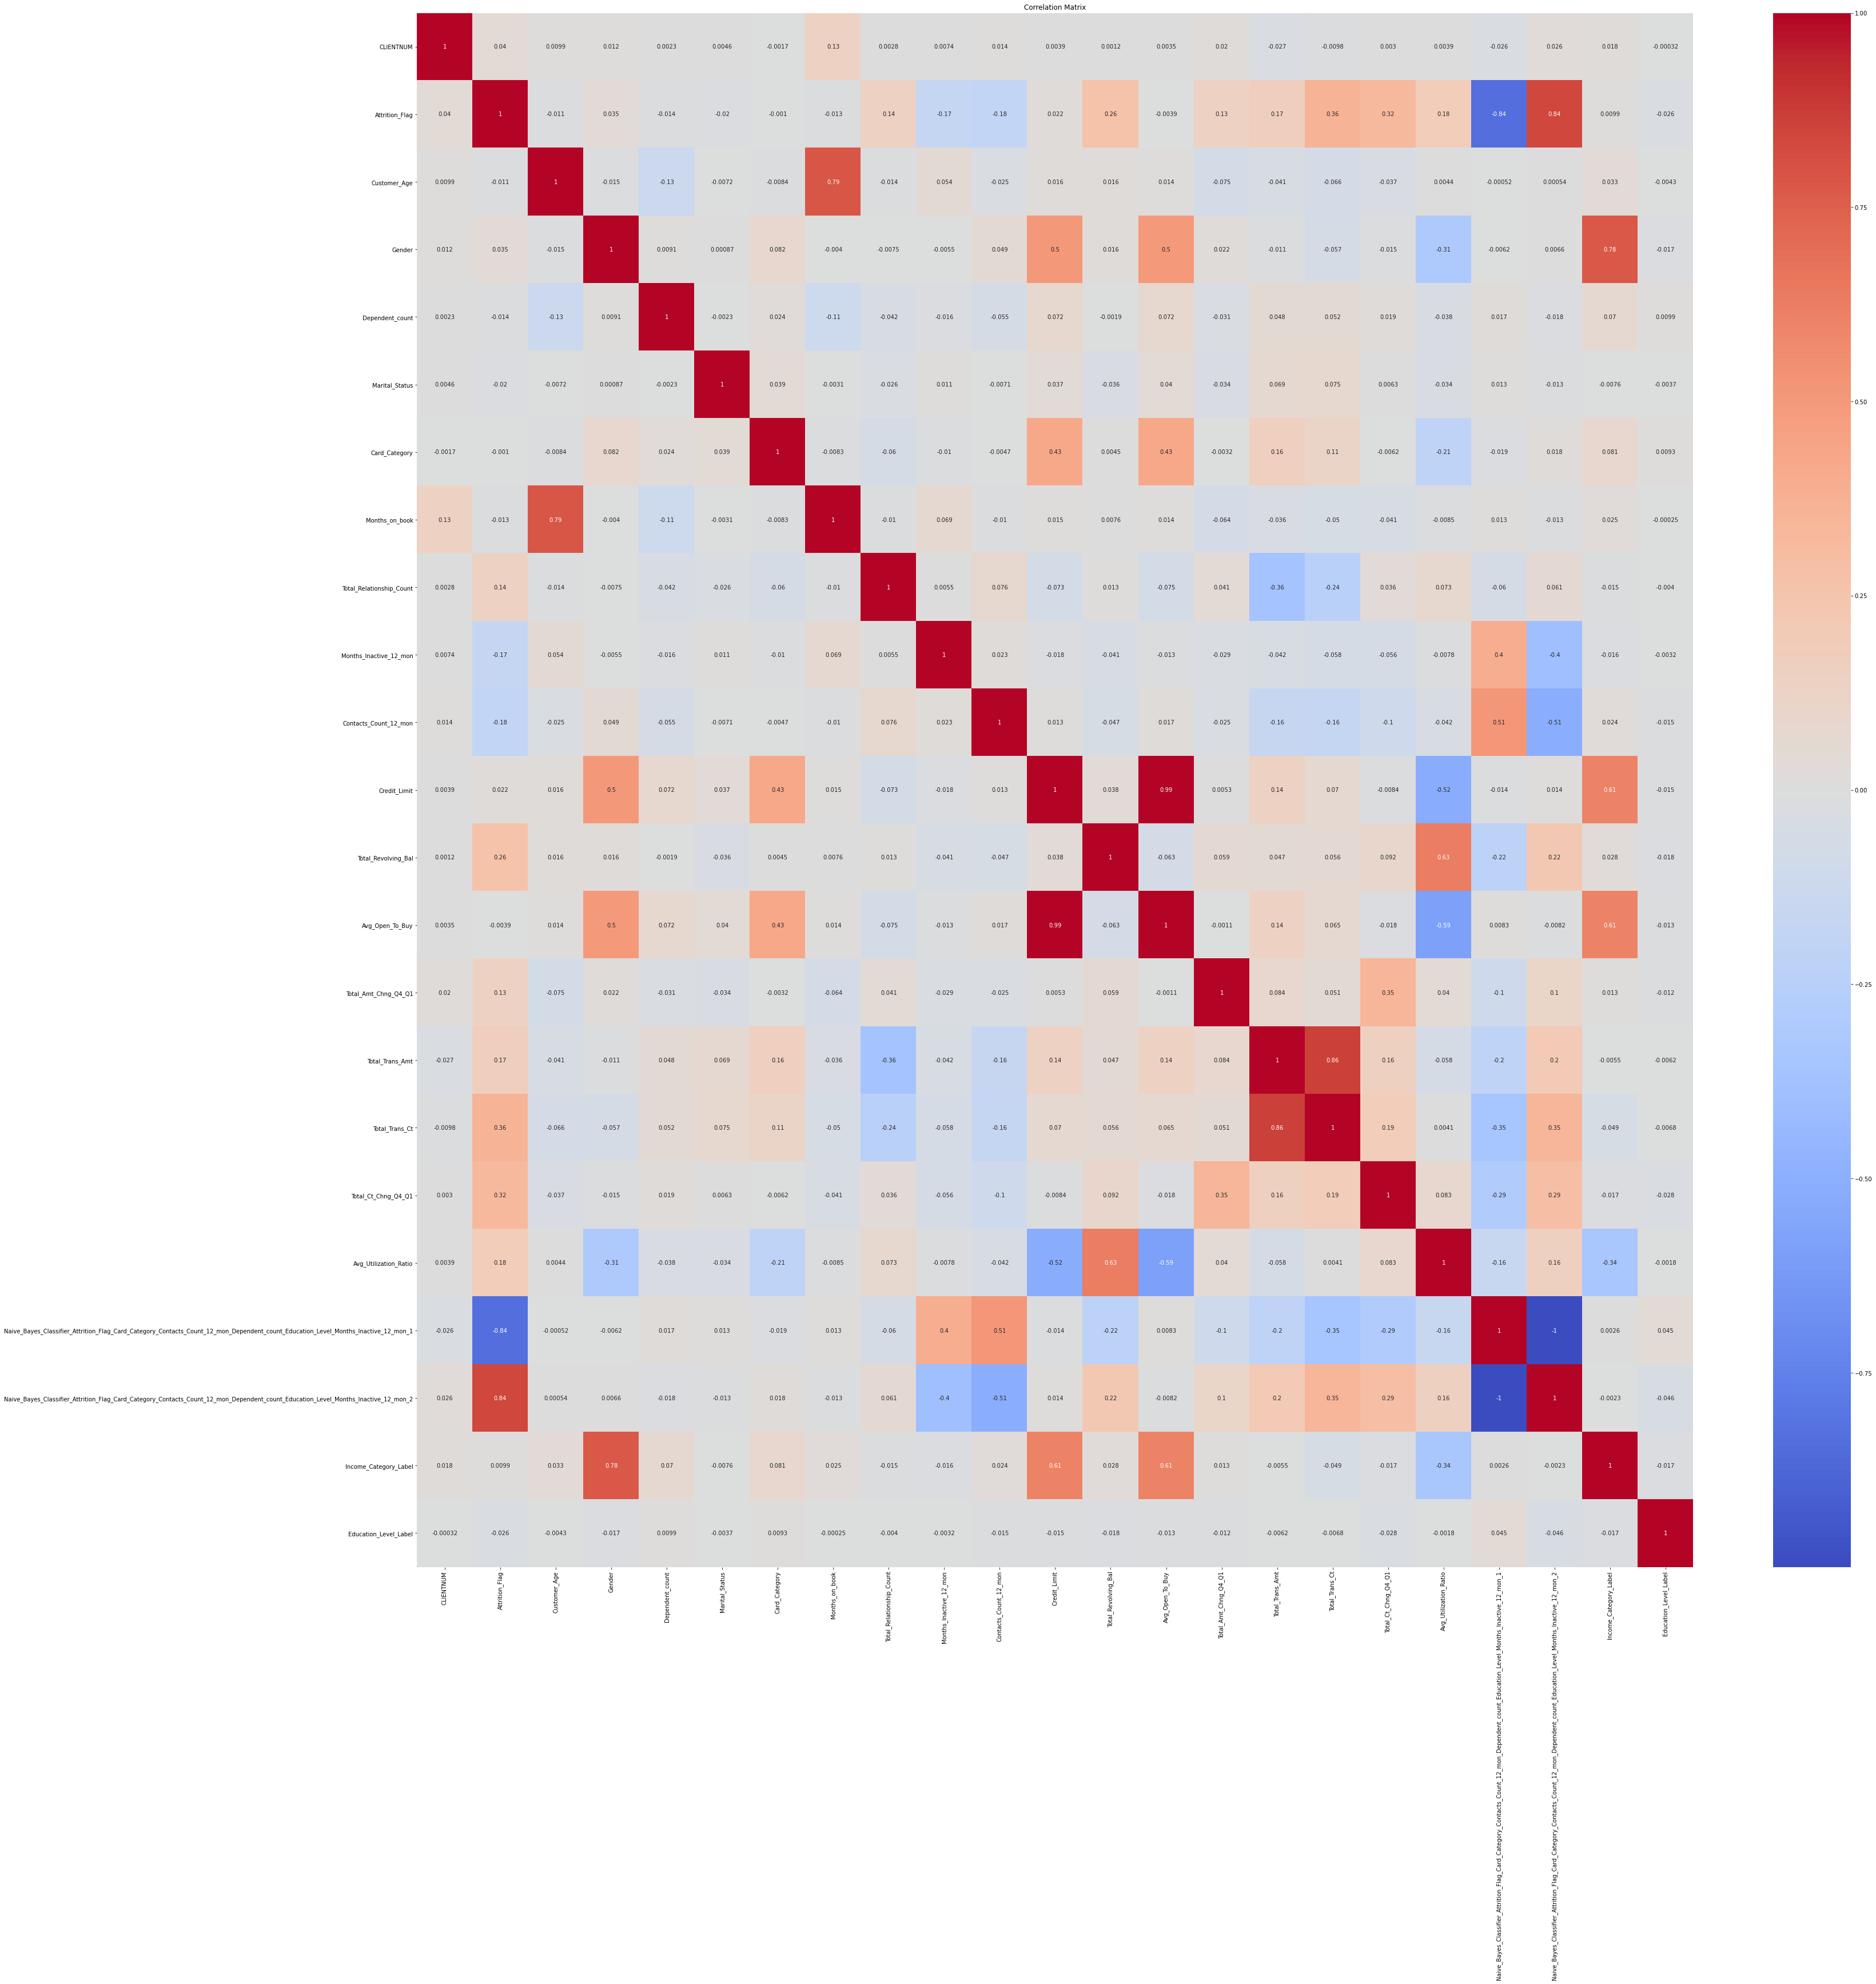

Descriptive Statistics:
         CLIENTNUM  Attrition_Flag  Customer_Age       Gender  \
count  7641.000000     7641.000000   7641.000000  7641.000000   
mean      0.000850        0.841513     -0.002795     0.525455   
std       1.000948        0.365221      0.992740     0.499384   
min      -0.842652        0.000000     -2.536030     0.000000   
25%      -0.708846        1.000000     -0.664455     0.000000   
50%      -0.576711        1.000000     -0.040597     1.000000   
75%       0.924378        1.000000      0.708033     1.000000   
max       2.416280        1.000000      2.766766     1.000000   

       Dependent_count  Marital_Status  Card_Category  Months_on_book  \
count      7641.000000     7641.000000    7641.000000     7641.000000   
mean          0.004097        1.457924       0.184923        0.002050   
std           0.993506        0.737436       0.702809        0.997287   
min          -1.806378        0.000000       0.000000       -2.372974   
25%          -1.036462   

In [38]:
plot_correlation_matrix(data, figsize=(50,50))

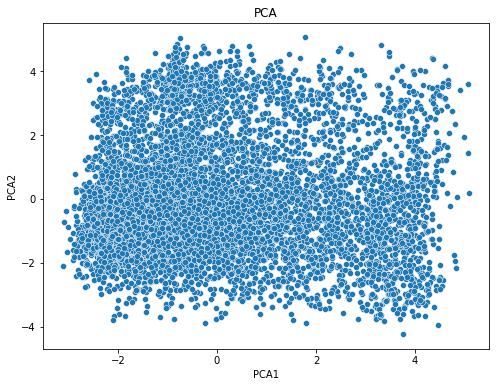

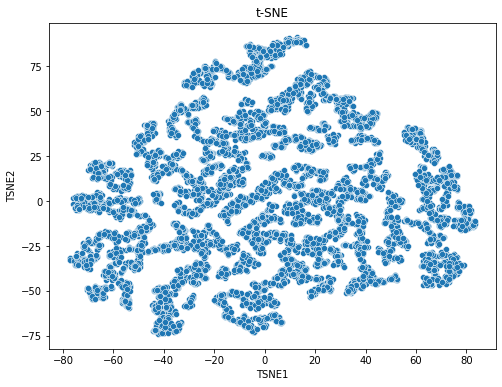

In [45]:
pca_result, tsne_result, _df = plot_PCA_TSNE(data_pca)

# Exploration of Mean Shift Parameters

In [55]:
bandwidths = [0.1, 0.3, 0.5, 0.7, 1.0]
for bw in bandwidths:
    print(f"Testing bandwidth: {bw}")
    labels = mean_shift(pca_result, bandwidth=bw)
    print(f"Number of clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")

Testing bandwidth: 0.1
Using bandwidth: 0.1
Silhouette Score: 0.3314451025042982
Number of clusters: 1544
Testing bandwidth: 0.3
Using bandwidth: 0.3
Silhouette Score: 0.26290476590085365
Number of clusters: 231
Testing bandwidth: 0.5
Using bandwidth: 0.5
Silhouette Score: 0.22878366244231527
Number of clusters: 52
Testing bandwidth: 0.7
Using bandwidth: 0.7
Silhouette Score: 0.31686524730254645
Number of clusters: 14
Testing bandwidth: 1.0
Using bandwidth: 1.0
Silhouette Score: 0.43520327140670817
Number of clusters: 4


# Quantile in Bandwidth Estimation

In [57]:
quantiles = [0.1, 0.2, 0.3, 0.5]
for q in quantiles:
    bandwidth = estimate_bandwidth(pca_result, quantile=q, n_samples=500)
    print(f"Quantile: {q}, Estimated Bandwidth: {bandwidth}")

Quantile: 0.1, Estimated Bandwidth: 1.322082789393162
Quantile: 0.2, Estimated Bandwidth: 1.9360709188619332
Quantile: 0.3, Estimated Bandwidth: 2.4030497703973586
Quantile: 0.5, Estimated Bandwidth: 3.222904877445613


# Visualisation

In [58]:
def visualize_clusters(data, labels, cluster_centers):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='red', marker='x', s=200, label='Centroids')
    plt.title("Mean Shift Clustering with Centroids")
    plt.legend()
    plt.show()

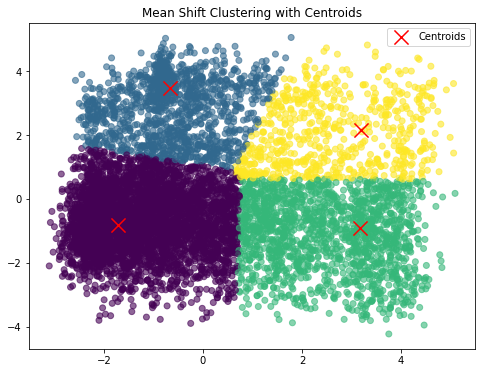

In [61]:
model = MeanShift(bandwidth=1.0)
model.fit(pca_result)
visualize_clusters(pca_result, model.labels_, model.cluster_centers_)

# Compare Clustering Metrics

In [64]:
print("Calinski-Harabasz Index:", calinski_harabasz_score(pca_result, labels))
print("Davies-Bouldin Index:", davies_bouldin_score(pca_result, labels))

Calinski-Harabasz Index: 6455.342875613338
Davies-Bouldin Index: 0.8248145765367102


# Comparison with Other Clustering Algorithms

C:\Users\mkami\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


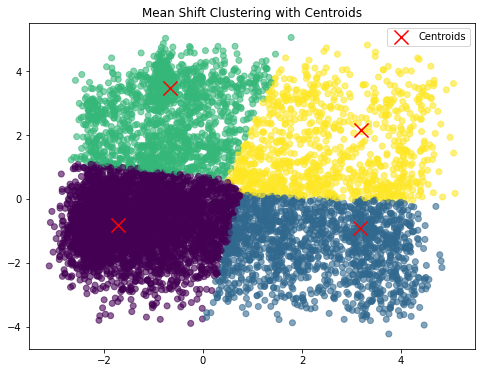

In [67]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_result)
visualize_clusters(pca_result, kmeans_labels, model.cluster_centers_)

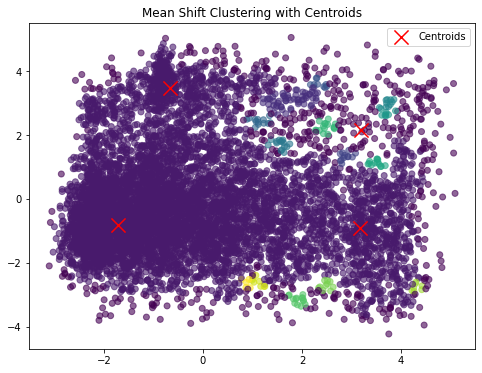

In [72]:
dbscan = DBSCAN(eps=0.2, min_samples=10)
dbscan_labels = dbscan.fit_predict(pca_result)
visualize_clusters(pca_result, dbscan_labels,model.cluster_centers_)

In [2]:
pip install cv

Note: you may need to restart the kernel to use updated packages.


# Image Clsutering

In [3]:
def mean_shift_clustering(image_data, bandwidth):
    mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    labels = mean_shift.fit_predict(image_data)
    centers = mean_shift.cluster_centers_
    return labels, centers

In [7]:
image_path = r'D:\MSCS\Semester-III\ML-II\Class Ativities\MEAN SHIFT\mypic.png'

Image loaded successfully.


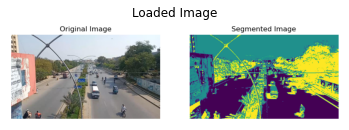

In [16]:
# Load the image from the local path
image = cv2.imread(image_path)
if image is not None:
    print("Image loaded successfully.")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title('Loaded Image')
    plt.axis('off')  
    plt.show()
else:
    print("Failed to load image. Please check the file path.")

In [17]:
lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB).reshape((-1, 3))
labels, centers = mean_shift_clustering(lab_image, bandwidth=30)

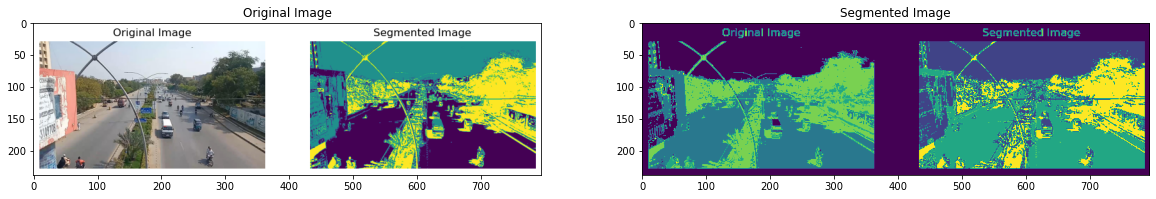

In [20]:
# Visualization
segmented_image = labels.reshape(image.shape[:2]) 

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
plt.title('Original Image')
plt.subplot(122)
plt.imshow(segmented_image) 
plt.title('Segmented Image')
plt.show()

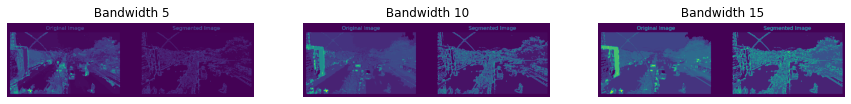

In [30]:
bandwidth_values = [5,10,15]
results = {}

for bandwidth in bandwidth_values:
    labels, centers = mean_shift_clustering(lab_image, bandwidth=bandwidth)
    segmented_image = labels.reshape(image.shape[:2])
    results[bandwidth] = segmented_image

plt.figure(figsize=(15, 5))
for i, bandwidth in enumerate(bandwidth_values, 1):
    plt.subplot(1, len(bandwidth_values), i)
    plt.imshow(results[bandwidth], cmap='viridis')
    plt.title(f' Bandwidth {bandwidth}')
    plt.axis('off')
plt.show()